# Anomaly detection test|NPB_cg

### Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Sequence alignment

In [2]:
def caculateMse_R2(x,y,p):
    y_pre = [p(i) for i in x]
    score = r2_score(y, y_pre, multioutput='raw_values')
    return score[0]

def list_set(x,y):
    list=[]
    for i in range(0,len(x)):
        list.append([x[i],y[i]])
    return list

def data_set_fix(list,x):
    n=0;
    data=0;
    for i in range(0,len(list)):
        if n==0:
            if list[i][0]==x:
                n=1
                data=list[i][1]
        else:
            list[i][1]=data
    
    return list


In [3]:
def align_data_singe(x,y,x1,n):
    
    while True:
        coef = np.polyfit(x,y, n)
        poly_fit = np.poly1d(coef)
        R2 = caculateMse_R2(x,y,poly_fit)
        if n>=19:
            break
        if R2>0.9:
            break
        else:
            n=n+1 
        
    
    data_set = list_set(x,y)
    
    for i in range(0,len(x1)):
         data_set.append([x1[i],poly_fit(x1[i])])
    
    data_set.sort();
    
    return data_set
    
def align_data(x1,y1,x2,y2):
    timeseries1 = align_data_singe(x1,y1,x2,6)
    timeseries2 = align_data_singe(x2,y2,x1,6)
    
    if(len(x1)>len(x2)):
        timeseries2 = data_set_fix(timeseries2,x2[-1])
    else:
        timeseries1 = data_set_fix(timeseries1,x1[-1])
    
    return timeseries1,timeseries2

### Sequence attribute and feature evaluation algorithm

In [4]:
def calculate_attenuate_weight(seqLen1, seqLen2, com_ls):
    weight = 0
    for comlen in com_ls:
        weight = weight + comlen / seqLen1 * comlen / seqLen2
    return 1 - weight

def DTWDistance(s1, s2):
    sdt = np.std(s1, ddof=1) if np.std(s1, ddof=1) > np.std(s2, ddof=1) else np.std(s2, ddof=1)
    l1 = len(s1)
    l2 = len(s2)
    paths = np.full((l1 + 1, l2 + 1), np.inf)
    sub_matrix = np.full((l1, l2), 0)
    max_sub_len = 0

    paths[0, 0] = 0
    for i in range(l1):
        for j in range(l2):
            d = s1[i] - s2[j]
            cost = d ** 2
            paths[i + 1, j + 1] = cost + min(paths[i, j + 1], paths[i + 1, j], paths[i, j])
            if np.abs(s1[i] - s2[j]) < sdt:
                if i == 0 or j == 0:
                    sub_matrix[i][j] = 1
                else:
                    sub_matrix[i][j] = sub_matrix[i - 1][j - 1] + 1
                    max_sub_len = sub_matrix[i][j] if sub_matrix[i][j] > max_sub_len else max_sub_len

    paths = np.sqrt(paths)
    s = paths[l1, l2]

    return s


In [5]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

In [6]:
def Dtw_LB_conter(data1,data2,r):
    l=LB_Keogh(data1,data2,r)+DTWDistance(data1,data2)
    return l/2

def getMin(a,b):
    if a<b:
        return a
    else:
        return b

In [7]:
def timeseries_score(s1,s2,w,r):
    
    time_s1_s2 = s2[0][len(s2[0])-1]/s1[0][len(s1[0])-1]
    
    time_sum=0;
    for i in range(math.ceil(len(s1[0])/w)):
        s1_time = sum(s1[0][i:i+w])
        s2_time = sum(s2[0][i:i+w])
        i=i+w
        time_sum =time_sum + s2_time/s1_time    

    time_sum = time_sum/math.ceil(len(s1[0])/w)
    
    heartbeat_s1 = (sum(s1[1])/len(s1[1]))
    heartbeat_s1_s2 = sum(s2[1])/len(s2[1])/(sum(s1[1])/len(s1[1]))
    
    heartbeat_sum=0;
    for i in range(math.ceil(len(s1[1])/w)):
        s1_heartbeat = sum(s1[1][i:i+w])
        s2_heartbeat = sum(s2[1][i:i+w])
        i=i+w
        heartbeat_sum =heartbeat_sum + s2_heartbeat/s1_heartbeat    

    heartbeat_sum = heartbeat_sum/math.ceil(len(s1[1])/w)
    
    slope_sum=0;
    for i in range(math.ceil(getMin(len(s1[1])/r,len(s2[1])/r))):
        
        k=i+r
        if(k>len(s1[1])):
            k=len(s1[1])  
        
        s1_slope = (s1[1][i]-s1[1][k])/(s1[0][i]-s1[0][k])
        s2_slope = (s2[1][i]-s2[1][k])/(s2[0][i]-s2[0][k])
        
        i=i+r
        slope_sum =slope_sum + abs(s2_slope/s1_slope)    

    slope_sum = slope_sum/math.ceil(math.ceil(len(s1[1])/r))

    return [time_s1_s2,time_sum,heartbeat_s1,heartbeat_s1_s2,heartbeat_sum,slope_sum]

In [8]:
def similar_all(x1,y1,x2,y2,tS1,tS2):
    x_p1 =[ tS1[i][0] for i in range(0,len(tS1))]
    y_p1 =[ tS1[i][1] for i in range(0,len(tS1))]
    x_p2 =[ tS2[i][0] for i in range(0,len(tS2))]
    y_p2 =[ tS2[i][1] for i in range(0,len(tS2))]
    
    feature = timeseries_score([x1,y1],[x2,y2],20,5)
    distent = Dtw_LB_conter(y_p1,y_p2,100)
          
    return feature,distent

### Anomaly diagnosis function

In [9]:
min_time_standard = 0.750050
max_time_standard = 1.333244
min_hr_standard   = 0.757917
max_hr_standard   = 1.319404

def distent_check(h_distence):
    h_standard = 87763623465.4

    if h_distence<h_standard:
        return 2;
    else:
        return 1;
    

def dataseries_check(feature):
    
    time_check={}
    if feature[0]>min_time_standard*0.9 and feature[0]<max_time_standard*1.1:
        time_check[0]=2
    else:
        time_check[0]=1
    
    if feature[0]/feature[1]>0.90:
        time_check[1]=2
    else:
        time_check[1]=1
    
    heart={}
    if feature[3]>min_hr_standard*0.9 and feature[3]<max_hr_standard*1.1 :
        heart[0]=2
    else:
        heart[0]=1
    
    if feature[3]/feature[4]>0.90:
        heart[1]=2
    else:
        heart[1]=1
    
    return [time_check,heart]

In [10]:
def judge(feature):
    
    judge_distence = distent_check(feature[1])
    judge_dataseries = dataseries_check(feature[0])
    
    assis=0;
    check=0;
    
    print("judge_distence = "+str(judge_distence))
    print(judge_dataseries)
    if(judge_distence==2):
        t=0
        print("judge_dataseries[0][0]:"+str(judge_dataseries[0][0]))
        print("feature[0][0]:"+str(feature[0][0]))
        print("min_time_standard:"+str(min_time_standard))  
        print("judge_dataseries[0][0]:",judge_dataseries[0][0])
        if judge_dataseries[0][0] == 1 and feature[0][0]<min_time_standard*0.9:
            t=2
            check=2
            if judge_dataseries[0][1]==1:
                assis=1;
        print("feature[0][0] = "+str(feature[0][0]))
        if judge_dataseries[1][0]==1 and  t!=2 and feature[0][0]>max_time_standard*1.1:
            check=1
            if judge_dataseries[1][1]==1:
                assis=1;
    
    elif judge_distence==1:
        t=0
        check=1
        if judge_dataseries[0][0]==1 and feature[0][0]<min_time_standard*0.9:
            check=2
            t=2
            if judge_dataseries[0][1]==1:
                assis=1;
        print("feature[0][0]:"+str(feature[0][0]))
        print("max_time_standard:"+str(max_time_standard))  
        if judge_dataseries[1][0]==1 and t!=2 and feature[0][0]>max_time_standard*1.1:
            if t==1:
                check=1
            if judge_dataseries[1][1]==1:
                assis=1;    
    
    if(check==0 and assis==0):
        print("Normal：","Two heartbeat sequences are highly consistent, and the thread status is normal.")
    elif(check==0 and assis==1):
        print("Normal：","Two heartbeat sequences have high consistency. The thread status is normal, yet the local oscillation is intense.")
    elif(check==1 and assis==0):
        print("Memory leak：","The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak.")
    elif(check==1 and assis==1):
        print("Memory leak：","The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak with intense local oscillation.")    
    elif(check==2 and assis==0):
        print("Shutdown：","The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is shutdown.")
    elif(check==2 and assis==1):
        print("Shutdown：","The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is shutdown with intense local oscillation.")
    return [check,assis]
    

### experiment

#### Import Data

In [11]:
data = pd.read_excel('../../Dataset/cg_std_normal_1.xlsx',hearder=None,sheet_name=None)
x = data['1']['time'].copy()[0:999]
y = data['1']['heartrate'].copy()[0:999]
x = np.array(x)
y = np.array(y)

In [12]:
normal = pd.read_excel('../../Dataset/cg_std_normal.xlsx',hearder=None,sheet_name=None)
len(normal)

30

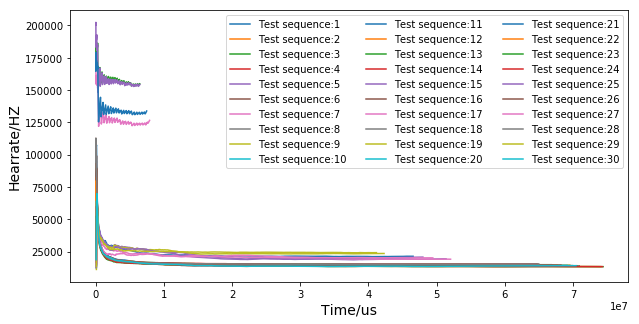

In [13]:
plt.figure(figsize=(10,5))
data = pd.read_excel('../../Dataset/cg_std_abs.xlsx',hearder=None,sheet_name=None)
k=1 
for i in data: 
    x6 = data[i]['time'].copy()[0:999]
    y6 = data[i]['heartrate'].copy()[0:999]
    label_name = 'Test sequence:'+str(k)
    plt.plot(x6,y6,label=label_name)
    k = k+1
plt.xlabel('Time/us',fontsize=14)
plt.ylabel('Hearrate/HZ',fontsize=14)
plt.legend(loc=0,ncol=3,borderaxespad=0.5)   
plt.show()

#### Normal thread detection experiment

In [14]:
SeriesFeature=[]
SeriesResult=[]

def normal_lab():
    
    for i in normal:
        title_times = "Proceed to serial number："+str(i)+"："
        print(title_times)
        x2 = normal[i]['time'].copy()[0:999]
        y2 = normal[i]['heartrate'].copy()[0:999]
        x2 = np.array(x2)
        y2 = np.array(y2)
        timeSeries1,timeSeries2 = align_data(x,y,x2,y2)

        feature = similar_all(x,y,x2,y2,timeSeries1,timeSeries2)

        SeriesFeature.append(feature)
        
        check=judge(feature)
        
        SeriesResult.append(check)
    
normal_lab()

Proceed to serial number：1：
judge_distence = 2
[{0: 2, 1: 2}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
feature[0][0]:1.0
min_time_standard:0.75005
judge_dataseries[0][0]: 2
feature[0][0] = 1.0
Normal： Two heartbeat sequences are highly consistent, and the thread status is normal.
Proceed to serial number：2：
judge_distence = 2
[{0: 2, 1: 2}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
feature[0][0]:0.7505942142345142
min_time_standard:0.75005
judge_dataseries[0][0]: 2
feature[0][0] = 0.7505942142345142
Normal： Two heartbeat sequences are highly consistent, and the thread status is normal.
Proceed to serial number：3：
judge_distence = 2
[{0: 2, 1: 2}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
feature[0][0]:0.7708499507273218
min_time_standard:0.75005
judge_dataseries[0][0]: 2
feature[0][0] = 0.7708499507273218
Normal： Two heartbeat sequences are highly consistent, and the thread status is normal.
Proceed to serial number：4：
judge_distence = 2
[{0: 2, 1: 2}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
fe

judge_distence = 2
[{0: 2, 1: 1}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
feature[0][0]:0.8232761694980131
min_time_standard:0.75005
judge_dataseries[0][0]: 2
feature[0][0] = 0.8232761694980131
Normal： Two heartbeat sequences are highly consistent, and the thread status is normal.
Proceed to serial number：29：
judge_distence = 2
[{0: 2, 1: 2}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
feature[0][0]:1.0699826564927601
min_time_standard:0.75005
judge_dataseries[0][0]: 2
feature[0][0] = 1.0699826564927601
Normal： Two heartbeat sequences are highly consistent, and the thread status is normal.
Proceed to serial number：30：
judge_distence = 2
[{0: 2, 1: 1}, {0: 2, 1: 2}]
judge_dataseries[0][0]:2
feature[0][0]:0.8375734186679854
min_time_standard:0.75005
judge_dataseries[0][0]: 2
feature[0][0] = 0.8375734186679854
Normal： Two heartbeat sequences are highly consistent, and the thread status is normal.


In [15]:
def precisionRate(result):
    num=0
    for i in result:
        if i[0]==1 or i[0]==2:
            num=num+1
    print("Accuracy:",(len(result)-num)/len(result))
precisionRate(SeriesResult) 

Accuracy: 1.0


#### Memory leak check test

In [16]:
abnormal = pd.read_excel('../../Dataset/cg_std_abs.xlsx',hearder=None,sheet_name=None)
len(abnormal)

30

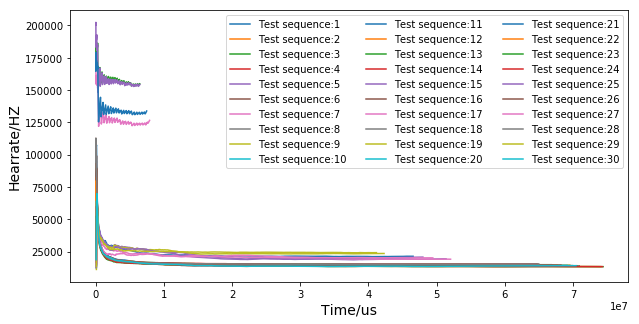

In [17]:
plt.figure(figsize=(10,5))
data = pd.read_excel('../../Dataset/cg_std_abs.xlsx',hearder=None,sheet_name=None)
k=1 
for i in data: 
    x6 = data[i]['time'].copy()[0:999]
    y6 = data[i]['heartrate'].copy()[0:999]
    label_name = 'Test sequence:'+str(k)
    plt.plot(x6,y6,label=label_name)
    k = k+1
plt.xlabel('Time/us',fontsize=14)
plt.ylabel('Hearrate/HZ',fontsize=14)
plt.legend(loc=0,ncol=3,borderaxespad=0.5)   
plt.show()

In [18]:
SeriesFeature1=[]
SeriesResult1=[]

def abnormal_lab():
    
    for i in abnormal:
        title_times = "Proceed to serial number："+str(i)+"："
        print(title_times)
        x2 = abnormal[i]['time'].copy()[1:999]

        y2 = abnormal[i]['heartrate'].copy()[1:999]
        x2 = np.array(x2)
        y2 = np.array(y2)
        timeSeries1,timeSeries2 = align_data(x,y,x2,y2)

        feature = similar_all(x,y,x2,y2,timeSeries1,timeSeries2)

        SeriesFeature1.append(feature)
        
        check=judge(feature)
        
        SeriesResult1.append(check)
    
abnormal_lab()

Proceed to serial number：2_1：
judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 1}]
feature[0][0]:6.915377444168528
max_time_standard:1.333244
Memory leak： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak with intense local oscillation.
Proceed to serial number：2_2：
judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 1}]
feature[0][0]:10.053402162529704
max_time_standard:1.333244
Memory leak： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak with intense local oscillation.
Proceed to serial number：2_3：
judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 1}]
feature[0][0]:9.925776118977172
max_time_standard:1.333244
Memory leak： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak with intense local oscillation.
Proceed to serial number：2_4：
judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 1}]
feature[0

judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 1}]
feature[0][0]:9.651587335079174
max_time_standard:1.333244
Memory leak： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak with intense local oscillation.
Proceed to serial number：2_29：
judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 2}]
feature[0][0]:6.116358113112001
max_time_standard:1.333244
Memory leak： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak.
Proceed to serial number：2_30：
judge_distence = 1
[{0: 1, 1: 2}, {0: 1, 1: 1}]
feature[0][0]:10.46691969682741
max_time_standard:1.333244
Memory leak： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is memory leak with intense local oscillation.


In [19]:
def precisionRate1(result):
    num=0
    for i in result:
        if i[0]==1 :
            num=num+1
    print("Accuracy:",(num/len(result)))
precisionRate1(SeriesResult1)

Accuracy: 0.8666666666666667


### Shutdown test

In [20]:
shutdown = pd.read_excel('../../Dataset/cg_std_shut.xlsx',hearder=None,sheet_name=None)
len(shutdown)

30

In [21]:
SeriesFeature2=[]
SeriesResult2=[]

def shutdown_lab():
    for i in shutdown:
        title_times = "Proceed to serial number："+str(i)+"："
        print(title_times)
        x2 = shutdown[i]['time'].copy()[0:len(shutdown[i])]
        y2 = shutdown[i]['heartrate'].copy()[0:len(shutdown[i])]
        x2 = np.array(x2)
        y2 = np.array(y2)
        timeSeries1,timeSeries2 = align_data(x,y,x2,y2)

        feature = similar_all(x,y,x2,y2,timeSeries1,timeSeries2)

        SeriesFeature2.append(feature)
        
        check=judge(feature)
        
        SeriesResult2.append(check)

    
shutdown_lab()

Proceed to serial number：3_1：
judge_distence = 2
[{0: 1, 1: 1}, {0: 1, 1: 1}]
judge_dataseries[0][0]:1
feature[0][0]:0.12870748671301904
min_time_standard:0.75005
judge_dataseries[0][0]: 1
feature[0][0] = 0.12870748671301904
Shutdown： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is shutdown with intense local oscillation.
Proceed to serial number：3_2：
judge_distence = 2
[{0: 1, 1: 2}, {0: 1, 1: 1}]
judge_dataseries[0][0]:1
feature[0][0]:0.1355468197428311
min_time_standard:0.75005
judge_dataseries[0][0]: 1
feature[0][0] = 0.1355468197428311
Shutdown： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is shutdown.
Proceed to serial number：3_3：
judge_distence = 2
[{0: 1, 1: 2}, {0: 1, 1: 1}]
judge_dataseries[0][0]:1
feature[0][0]:0.13516791344175302
min_time_standard:0.75005
judge_dataseries[0][0]: 1
feature[0][0] = 0.13516791344175302
Shutdown： The heartbeat sequences of

judge_distence = 2
[{0: 1, 1: 2}, {0: 1, 1: 1}]
judge_dataseries[0][0]:1
feature[0][0]:0.16214336744579708
min_time_standard:0.75005
judge_dataseries[0][0]: 1
feature[0][0] = 0.16214336744579708
Shutdown： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is shutdown.
Proceed to serial number：3_25：
judge_distence = 2
[{0: 1, 1: 2}, {0: 1, 1: 1}]
judge_dataseries[0][0]:1
feature[0][0]:0.16479110524144802
min_time_standard:0.75005
judge_dataseries[0][0]: 1
feature[0][0] = 0.16479110524144802
Shutdown： The heartbeat sequences of two threads have low consistency. The thread status is abnormal, and its status is shutdown.
Proceed to serial number：3_26：
judge_distence = 2
[{0: 1, 1: 2}, {0: 1, 1: 1}]
judge_dataseries[0][0]:1
feature[0][0]:0.16461249921246926
min_time_standard:0.75005
judge_dataseries[0][0]: 1
feature[0][0] = 0.16461249921246926
Shutdown： The heartbeat sequences of two threads have low consistency. The thread status is a

In [22]:
def precisionRate2(result):
    num=0
    for i in result:
        if i[0]==2:
            num=num+1
    print("Accuracy:",(num/len(result)))
precisionRate2(SeriesResult2)

Accuracy: 1.0


### All result

In [23]:
def resultValue():
    Result_all_pre=[]
    Result_all_true=[]
    for i in SeriesResult:
        Result_all_pre.append(i[0])
        Result_all_true.append(0)

    for i in SeriesResult1:
        Result_all_pre.append(i[0])
        Result_all_true.append(1)

    for i in SeriesResult2:
        Result_all_pre.append(i[0])
        Result_all_true.append(2)
    
    return [Result_all_pre,Result_all_true]


In [24]:
from sklearn.metrics import classification_report

In [25]:
resultvalue = resultValue()
acc_num=0
for i in range(len(resultvalue[1])):
    
    if(resultvalue[0][i]==resultvalue[1][i]):
        acc_num=acc_num+1

print("Accuracy:",acc_num/len(resultvalue[0]))

print(classification_report(resultvalue[0], resultvalue[1], labels=[0, 1, 2]))

Accuracy: 0.9555555555555556
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        34
           1       0.87      1.00      0.93        26
           2       1.00      1.00      1.00        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90

